# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
#!pip install --upgrade scikit-learn
#!pip install --upgrade shap matplotlib
#!pip install shap
#!pip install phik
#!pip install --upgrade seaborn

In [2]:
from scipy import stats
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import shap
import os

from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    r2_score, 
    mean_absolute_error,
    root_mean_squared_error 
)
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    KFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor

In [3]:
pth1 = '/datasets/geo_data_0.csv'
pth2 = '/datasets/geo_data_1.csv'
pth3 = '/datasets/geo_data_2.csv'

if os.path.exists(pth1):
    df_1 = pd.read_csv(pth1, index_col='id')
else:
    print('Something is wrong_1')
    
if os.path.exists(pth2):
    df_2 = pd.read_csv(pth2, index_col='id')
else:
    print('Something is wrong_2')

if os.path.exists(pth3):
    df_3 = pd.read_csv(pth3, index_col='id')
else:
    print('Something is wrong_3')

Условия задачи:

In [4]:
MONEY = 1e10           # руб. Бюджет;
PROF_PER_BARREL = 450  # руб/баррель. Прибыль с одного барреля;
TO_BUILD = 200         # Сколько будет построено вышек;
TO_EXPLORE = 500       # Из скольки вышек будут выбирать.

Изучим *df_1*:

In [5]:
df_1.head(10)

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647
wX4Hy,0.969570,0.489775,-0.735383,64.741541
tL6pL,0.645075,0.530656,1.780266,49.055285
BYPU6,-0.400648,0.808337,-5.624670,72.943292
j9Oui,0.643105,-0.551583,2.372141,113.356160


In [6]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [7]:
df_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [8]:
df_1.duplicated().sum()

0

Изучим *df_2*:

In [9]:
df_2.head(10)

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305
HHckp,-3.327590,-2.205276,3.003647,84.038886
h5Ujo,-11.142655,-10.133399,4.002382,110.992147
muH9x,4.234715,-0.001354,2.004588,53.906522
YiRkx,13.355129,-0.332068,4.998647,134.766305


In [10]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [11]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [12]:
df_2.duplicated().sum()

0

Изучим *df_3*:

In [13]:
df_3.head(10)

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746
LzZXx,-0.758092,0.710691,2.585887,90.222465
WBHRv,-0.574891,0.317727,1.773745,45.641478
XO8fn,-1.906649,-2.458350,-0.177097,72.480640
ybmQ5,1.776292,-0.279356,3.004156,106.616832


In [14]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [15]:
df_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [16]:
df_3.duplicated().sum()

0

In [17]:
#Функция построения плотности распределения величины
def kdeplot_with_norm(df, features):
    number_row = int(len(features)/3)
    fig, ax = plt.subplots(nrows = number_row + 1, ncols=2, figsize=(15, 5))
    ax = ax.flatten()
    for i in range(len(features)):
        sns.kdeplot(data = df, x = df[features[i]], ax=ax[i], common_norm=False, fill=True, alpha=0.7)
        ax[i].set_title(f'Гистограмма по столбцу {features[i]}')
        ax[i].set_xlabel('')
  

    fig.tight_layout()
    fig.show()

Графики по всем величинам:

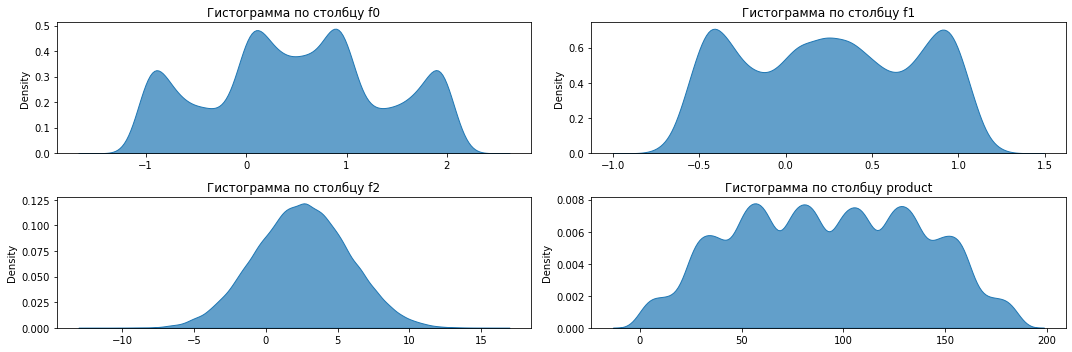

In [18]:
features = df_1.select_dtypes(include='number').columns.tolist()
kdeplot_with_norm(df_1, features)

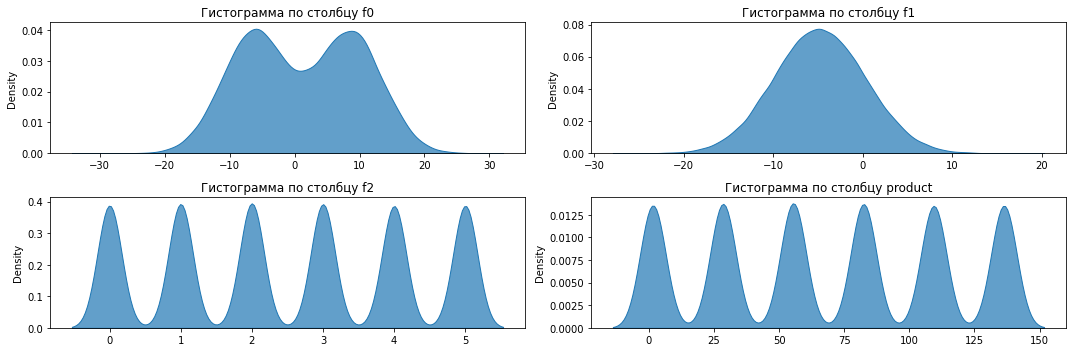

In [19]:
kdeplot_with_norm(df_2, features)

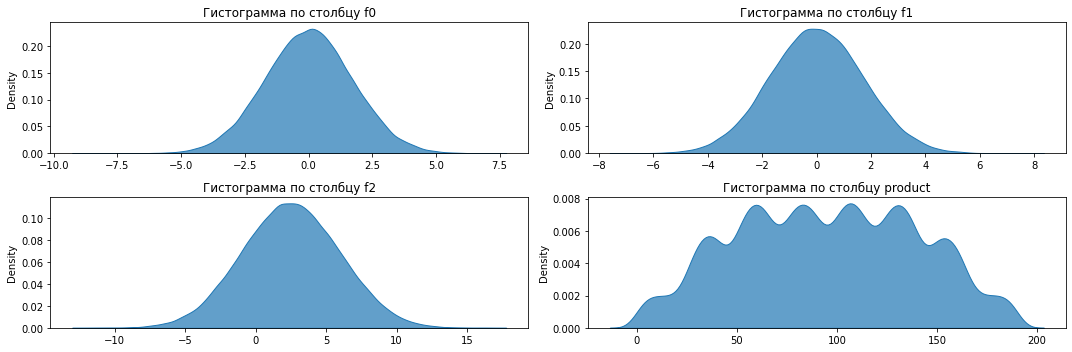

In [20]:
kdeplot_with_norm(df_3, features)

Пропусков и дубликатов нет. Все признаки имеют свое распределение. Данные синтетические, поэтому такая форма получившихся графиков.

Корреляционный анализ:

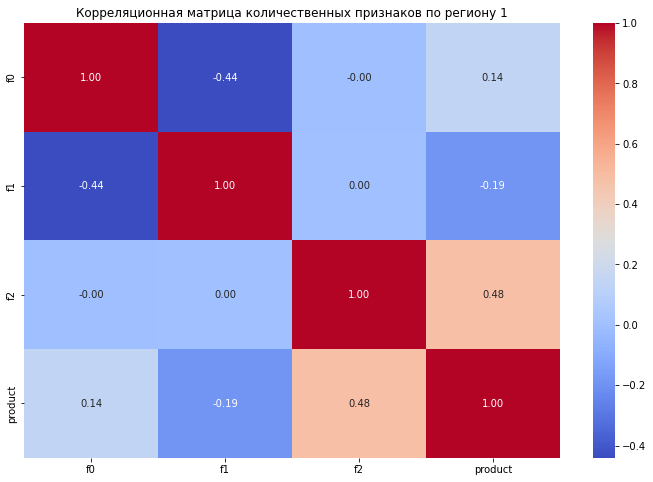

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_1.corr(), annot=True, cmap="coolwarm",fmt='.2f');
plt.title("Корреляционная матрица количественных признаков по региону 1")
plt.show()

Признаки связаны с целевым, без аномалий.

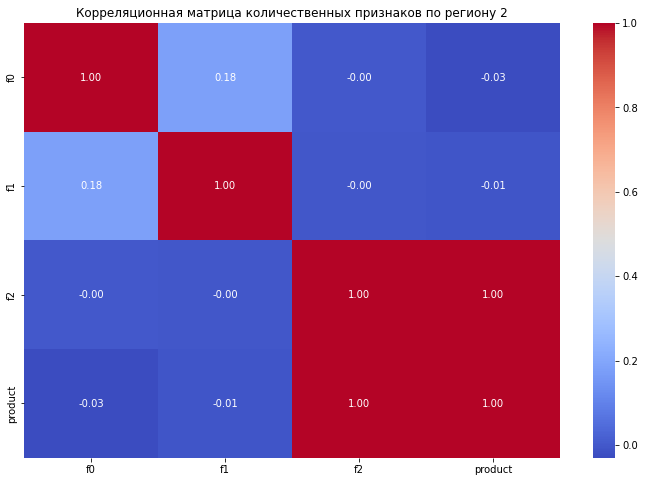

In [22]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_2.corr(), annot=True, cmap="coolwarm",fmt='.2f');
plt.title("Корреляционная матрица количественных признаков по региону 2")
plt.show()

Входной признак `f2` и `product` линейно связаны. А остальные признаки вообще не коррелируют.

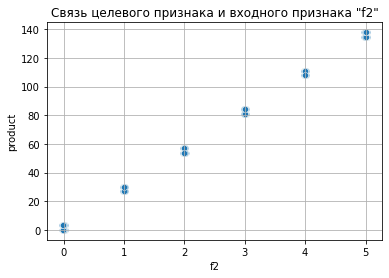

In [23]:
sns.scatterplot(x=df_2['f2'], y=df_2['product'])
plt.title('Связь целевого признака и входного признака "f2"')
plt.grid(True)
plt.show()

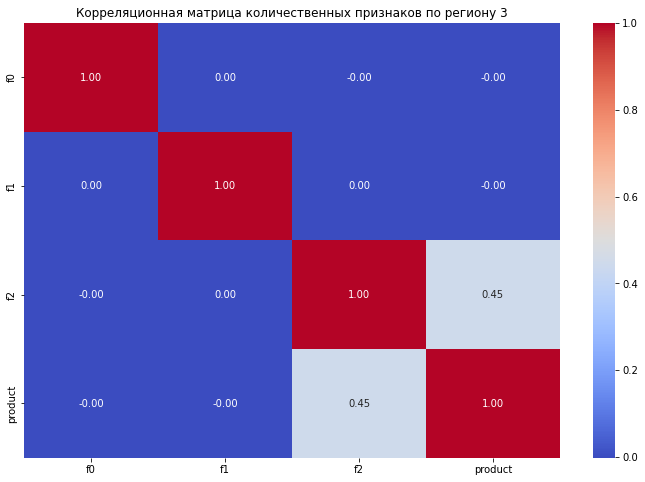

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_3.corr(), annot=True, cmap="coolwarm",fmt='.2f');
plt.title("Корреляционная матрица количественных признаков по региону 3")
plt.show()

С целевым признаком связан только признак `f2`.

## Обучение и проверка модели

Напишем пайплайн и обучим по модели на каждый регион:

df_1:

In [25]:
X = df_1.drop('product', axis=1)
y = df_1['product']
X_train, X_test, y_train, y_test_1 = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [26]:
num_col_names = X_train.columns.tolist()
num_pipe = Pipeline([('scaler', StandardScaler())])

In [27]:
data_preprocessor = ColumnTransformer([('num', num_pipe, num_col_names)])


pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

cv = KFold(n_splits=5, shuffle=True, random_state=1)

grid_1 = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [28]:
grid_1.fit(X_train, y_train)

y_test_pred_1 = grid_1.best_estimator_.predict(X_test)

print(f'Метрика RMSE лучшей модели: {root_mean_squared_error(y_test_1, y_test_pred_1):.2f} тыс. баррелей')
print(f'Средний запас предсказанного сырья: {y_test_pred_1.mean():.2f} тыс. баррелей')

Метрика RMSE лучшей модели: 37.74 тыс. баррелей
Средний запас предсказанного сырья: 92.49 тыс. баррелей


df_2:

In [29]:
X = df_2.drop('product', axis=1)
y = df_2['product']
X_train, X_test, y_train, y_test_2 = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [30]:
grid_2 = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [31]:
grid_2.fit(X_train, y_train)

y_test_pred_2 = grid_2.best_estimator_.predict(X_test)

print(f'Метрика RMSE лучшей модели: {root_mean_squared_error(y_test_2, y_test_pred_2):.2f} тыс. баррелей')
print(f'Средний запас предсказанного сырья: {y_test_pred_2.mean():.2f} тыс. баррелей')

Метрика RMSE лучшей модели: 0.89 тыс. баррелей
Средний запас предсказанного сырья: 69.12 тыс. баррелей


df_3:

In [32]:
X = df_3.drop('product', axis=1)
y = df_3['product']
X_train, X_test, y_train, y_test_3 = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [33]:
grid_3 = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [34]:
grid_3.fit(X_train, y_train)

y_test_pred_3 = grid_3.best_estimator_.predict(X_test)

print(f'Метрика RMSE лучшей модели: {root_mean_squared_error(y_test_3, y_test_pred_3):.2f} тыс. баррелей')
print(f'Средний запас предсказанного сырья: {y_test_pred_3.mean():.2f} тыс. баррелей')

Метрика RMSE лучшей модели: 39.87 тыс. баррелей
Средний запас предсказанного сырья: 94.96 тыс. баррелей


Наибольший средний запас предсказанного сырья находится в регионе 3 - 94.96 тыс. баррелей. Далее регион 1 - 92.49 тыс. баррелей. Меньше всего в регионе 2 - 69.12 тыс. баррелей.

## Подготовка к расчёту прибыли

In [35]:
#Приведем данные к типу pandas:
pred_1 = pd.Series(y_test_pred_1)
pred_2 = pd.Series(y_test_pred_2)
pred_3 = pd.Series(y_test_pred_3)

In [36]:
#Создадим новый датафрейм из истинных и предсказанных значений:
truepred_1 = pd.DataFrame({
    'pred': pred_1.values,  
    'true': y_test_1})
truepred_2 = pd.DataFrame({
    'pred': pred_2.values,  
    'true': y_test_2})
truepred_3 = pd.DataFrame({
    'pred': pred_3.values,  
    'true': y_test_3})

Рассчитаем объем сырья для безубыточного производства:

In [37]:
profitable_volume = MONEY / (PROF_PER_BARREL * 1000)  # тыс. баррелей

print(f"Безубыточный объем: {profitable_volume:.2f} тыс. баррелей")

Безубыточный объем: 22222.22 тыс. баррелей


In [38]:
print(f'Минимальный средний объем производства каждой их 200 скважин: {(profitable_volume / TO_BUILD):.2f} тыс. баррелей')

Минимальный средний объем производства каждой их 200 скважин: 111.11 тыс. баррелей


Минимальный средний объем производства каждой их 200 построенных скважин должен быть равен 111.11 тыс. баррелей.

## Расчёт прибыли и рисков 

In [39]:
#Функция по расчету прибыли
def profit(df):
    sum_prod = df.sort_values(by='pred', ascending=False)['true'][:TO_BUILD].sum()
    sum_profit = PROF_PER_BARREL*sum_prod*1000 - MONEY
    return sum_profit    

In [40]:
print(f'Чистая прибыль в регионе 1: {profit(truepred_1)/1e9:.4} млрд. руб.')
print(f'Чистая прибыль в регионе 2: {profit(truepred_2)/1e9:.4} млрд. руб.')
print(f'Чистая прибыль в регионе 3: {profit(truepred_3)/1e9:.4} млрд. руб.')

Чистая прибыль в регионе 1: 3.261 млрд. руб.
Чистая прибыль в регионе 2: 2.415 млрд. руб.
Чистая прибыль в регионе 3: 2.563 млрд. руб.


In [41]:
def bootstrap(df):
    state = np.random.RandomState(12345)

    values = []
    for i in range(1000):
        true_subsample = df['true'].sample(n=TO_EXPLORE, replace=True, random_state=state)
        
        values.append(profit(df.loc[true_subsample.index]))

    values = pd.Series(values)
    print(f'Чистая прибыль: {(values.mean())/1e9:.4} млрд. руб.')
    print(f"95% доверительный интервал: [{values.quantile(0.025)/1e9:.2f}, {values.quantile(0.975)/1e9:.2f}] млрд. руб.")
    print(f'Вероятность убытков: {(values<0).mean():.2%}')

In [42]:
print('Первый регион:')
bootstrap(truepred_1)

Первый регион:
Чистая прибыль: 0.4346 млрд. руб.
95% доверительный интервал: [-0.08, 0.97] млрд. руб.
Вероятность убытков: 5.90%


In [43]:
print('Второй регион:')
bootstrap(truepred_2)

Второй регион:
Чистая прибыль: 0.4744 млрд. руб.
95% доверительный интервал: [0.06, 0.86] млрд. руб.
Вероятность убытков: 1.00%


In [44]:
print('Третий регион:')
bootstrap(truepred_3)

Третий регион:
Чистая прибыль: 0.3999 млрд. руб.
95% доверительный интервал: [-0.11, 0.91] млрд. руб.
Вероятность убытков: 7.10%


- В регионе 1 вероятность убытков 5.90%
- В регионе 2 риск убытков = 1.10%, что подоходит по условию. 
- В регионе 3 риск убытков = 7.10% <br>
Оставлен только Регион 2. Его средняя прибыль = 0.4685 млрд. руб., причём 95 % ДИ полностью лежит выше нуля [0.06, 0.86] млрд руб с риском убытков 1.10%

## Вывод

1. На данных каждого региона обучено по модели. Получены предсказания объемов производства: Наибольший средний запас предсказанного сырья находится в регионе 3 - 94.96 тыс. баррелей (*RMSe* = 39.87 тыс. баррелей). Далее регион 1 - 92.49 тыс. баррелей (*RMSe* = 37.74 тыс. баррелей). Меньше всего в регионе 2 - 69.12 тыс. баррелей (*RMSe* = 0.89 тыс. баррелей).
2. Установлено, что минимальный средний объем производства каждой их 200 построенных скважин должен быть равен 111.11 тыс. баррелей, а общем безубыточном объеме, равном 22222.22 тыс. баррелей
3. Расчет прибыли и рисков по регионам:
    1. Первый регион: <br>
        Чистая прибыль: 0.4346 млрд. руб. <br>
        95% доверительный интервал: [-0.08, 0.97] млрд. руб. <br>
        Вероятность убытков: 5.90% <br>
    2. Второй регион: <br>
        Чистая прибыль: 0.4744 млрд. руб. <br>
        95% доверительный интервал: [0.06, 0.86] млрд. руб. <br>
        Вероятность убытков: 1.00% <br>
    3. Третий регион: <br>
        Чистая прибыль: 0.3999 млрд. руб. <br>
        95% доверительный интервал: [-0.11, 0.91] млрд. руб. <br>
        Вероятность убытков: 7.10% <br> <br>
  - В регионе 1 и в регионе 3 риск убытков равен 5.90% и 7.10% соответственно, что не подходит по условию. Они отпадают.
  - В регионе 2 риск убытков = 1.00%, что подоходит по условию. <br>

    Оставлен только Регион 2. Его средняя прибыль = 0.4744 млрд. руб., причём 95 % ДИ полностью лежит выше нуля [0.06, 0.86] млрд руб с риском убытков 1.00%   